# BIST50 Transformer Tabanlı Zaman Serisi Modelleri

## Çoklu Hisse Analizi (Çok Veri - ~12,500 Örnek)

| Model | Yıl | Açıklama |
|-------|-----|----------|
| **Informer** | 2021 | ProbSparse attention |
| **Autoformer** | 2021 | Auto-correlation |
| **FEDformer** | 2022 | Frequency enhanced |
| **TimesNet** | 2023 | 2D variation |
| **DeepAR** | 2020 | Probabilistic (Amazon) |
| **TFT** | 2021 | Temporal Fusion (Google) |
| **TSMixer** | 2023 | MLP-based |

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install neuralforecast pytorch-lightning

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import torch
import os

from neuralforecast import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, TimesNet, DeepAR, TFT, TSMixer

plt.style.use('fivethirtyeight')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

TEST_SIZE = 21
HORIZON = 21
INPUT_SIZE = 30

DATA_FILE = "/content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data_Full_Imputed.csv"
RESULTS_DIR = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/8_Transformers_Full'
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Veri: {DATA_FILE}")

Device: cuda
Veri: /content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data_Full_Imputed.csv


In [4]:
# Veri yükle
print("Veri yükleniyor...")
df_raw = pd.read_csv(DATA_FILE)
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%d.%m.%Y')

# Hisse listesi
tickers = [col.replace('_Now', '') for col in df_raw.columns if '_Now' in col]
print(f"Hisse sayısı: {len(tickers)}")

# Long format
data_list = []
for ticker in tickers:
    col = f'{ticker}_Now'
    if col in df_raw.columns:
        for _, row in df_raw.iterrows():
            price = row[col]
            if isinstance(price, str):
                price = float(price.replace('.', '').replace(',', '.'))
            if not pd.isna(price):
                data_list.append({'Date': row['Date'], 'Ticker': ticker, 'Close': price})

df_long = pd.DataFrame(data_list).sort_values(['Ticker', 'Date']).reset_index(drop=True)
print(f"Toplam satır: {len(df_long)}")

# Train/Test
train_list, test_list = [], []
for ticker in df_long['Ticker'].unique():
    df_t = df_long[df_long['Ticker'] == ticker].copy()
    if len(df_t) >= INPUT_SIZE + TEST_SIZE:
        train_list.append(df_t.iloc[:-TEST_SIZE])
        test_list.append(df_t.iloc[-TEST_SIZE:])

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# y_true
y_true = test_df['Close'].values

# NeuralForecast format
train_nf = train_df.rename(columns={'Date': 'ds', 'Close': 'y', 'Ticker': 'unique_id'})
train_nf = train_nf[['unique_id', 'ds', 'y']]

test_nf = test_df.rename(columns={'Date': 'ds', 'Close': 'y', 'Ticker': 'unique_id'})
test_nf = test_nf[['unique_id', 'ds', 'y']]

n_series = train_nf['unique_id'].nunique()
print(f"Train: {len(train_nf)}, Test: {len(test_nf)}, Hisse: {n_series}")

Veri yükleniyor...
Hisse sayısı: 50
Toplam satır: 12500
Train: 11450, Test: 1050, Hisse: 50


In [5]:
all_results = {}
all_predictions = {}

In [6]:
# TÜM MODELLERİ TEK SEFERDE EĞİT
print("="*80)
print(" TÜM TRANSFORMER MODELLERİ")
print("="*80)

models = [
    Informer(h=HORIZON, input_size=INPUT_SIZE, hidden_size=128, n_head=8, learning_rate=1e-3, max_steps=1000, batch_size=64, random_seed=42, scaler_type='standard'),
    Autoformer(h=HORIZON, input_size=INPUT_SIZE, hidden_size=128, n_head=8, learning_rate=1e-3, max_steps=1000, batch_size=64, random_seed=42, scaler_type='standard'),
    FEDformer(h=HORIZON, input_size=INPUT_SIZE, hidden_size=128, n_head=8, learning_rate=1e-3, max_steps=1000, batch_size=64, random_seed=42, scaler_type='standard'),
    TimesNet(h=HORIZON, input_size=INPUT_SIZE, hidden_size=128, learning_rate=1e-3, max_steps=1000, batch_size=64, random_seed=42, scaler_type='standard'),
    DeepAR(h=HORIZON, input_size=INPUT_SIZE, lstm_n_layers=3, lstm_hidden_size=128, learning_rate=1e-3, max_steps=1000, batch_size=64, random_seed=42, scaler_type='standard'),
    TFT(h=HORIZON, input_size=INPUT_SIZE, hidden_size=128, n_head=8, learning_rate=1e-3, max_steps=1000, batch_size=64, random_seed=42, scaler_type='standard'),
    TSMixer(h=HORIZON, input_size=INPUT_SIZE, n_series=n_series, n_block=4, ff_dim=128, learning_rate=1e-3, max_steps=1000, batch_size=64, random_seed=42, scaler_type='standard')
]

print(f"{len(models)} model eğitilecek...")
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train_nf)
print("✓ Eğitim tamamlandı!")

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42


 TÜM TRANSFORMER MODELLERİ


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


7 model eğitilecek...


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding │    384 │ train │     0 │
│ 4 │ dec_embedding │ DataEmbedding │    384 │ train │     0 │
│ 5 │ encoder       │ TransEncoder  │  199 K │ train │     0 │
│ 6 │ decoder       │ TransDecoder  │  141 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 341 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 341 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 73                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ enc_embedding │ DataEmbedding │    384 │ train │     0 │
│ 5 │ dec_embedding │ DataEmbedding │    384 │ train │     0 │
│ 6 │ encoder       │ Encoder       │  148 K │ train │     0 │
│ 7 │ decoder       │ Decoder       │  141 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 290 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 290 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 85                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ enc_embedding │ DataEmbedding │    384 │ train │     0 │
│ 5 │ dec_embedding │ DataEmbedding │    384 │ train │     0 │
│ 6 │ encoder       │ Encoder       │  179 K │ train │     0 │
│ 7 │ decoder       │ Decoder       │  214 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 395 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 395 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 80                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss           │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train   │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler         │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ model          │ ModuleList    │  9.4 M │ train │     0 │
│ 4 │ enc_embedding  │ DataEmbedding │    384 │ train │     0 │
│ 5 │ layer_norm     │ LayerNorm     │    256 │ train │     0 │
│ 6 │ predict_linear │ Linear        │  1.6 K │ train │     0 │
│ 7 │ projection     │ Linear        │    129 │ train │     0 │
└───┴────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 9.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.4 M                                                                                                
Total estimated model params size (MB): 37                                                                         
Modules in train mode: 50                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ DistributionLoss │      5 │ train │     0 │
│ 1 │ valid_loss   │ MAE              │      0 │ train │     0 │
│ 2 │ padder_train │ ConstantPad1d    │      0 │ train │     0 │
│ 3 │ scaler       │ TemporalNorm     │      0 │ train │     0 │
│ 4 │ hist_encoder │ LSTM             │  331 K │ train │     0 │
│ 5 │ decoder      │ Decoder          │    387 │ train │     0 │
└───┴──────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 331 K                                                                                            
Non-trainable params: 5                                                                                            
Total params: 331 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                    │ MAE                      │      0 │ train │     0 │
│ 1 │ padder_train            │ ConstantPad1d            │      0 │ train │     0 │
│ 2 │ scaler                  │ TemporalNorm             │      0 │ train │     0 │
│ 3 │ embedding               │ TFTEmbedding             │    512 │ train │     0 │
│ 4 │ temporal_encoder        │ TemporalCovariateEncoder │  613 K │ train │     0 │
│ 5 │ temporal_fusion_decoder │ TemporalFusionDecoder    │  252 K │ train │     0 │
│ 6 │ output_adapter          │ Linear                   │    129 │ train │     0 │
└───┴─────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 866 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 866 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ norm          │ RevINMultivariate │    100 │ train │     0 │
│ 4 │ mixing_layers │ Sequential        │ 79.6 K │ train │     0 │
│ 5 │ out           │ Linear            │    651 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 80.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 80.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 50                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


✓ Eğitim tamamlandı!


In [7]:
# Tahmin
print("Tahminler yapılıyor...")
predictions = nf.predict().reset_index()

# Test ile birleştir
predictions['ds'] = pd.to_datetime(predictions['ds'])
test_nf['ds'] = pd.to_datetime(test_nf['ds'])
eval_df = predictions.merge(test_nf, on=['unique_id', 'ds'], how='left')

print(f"Evaluation: {eval_df.shape}")
print(f"Sütunlar: {eval_df.columns.tolist()}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Tahminler yapılıyor...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Evaluation: (1050, 16)
Sütunlar: ['index', 'unique_id', 'ds', 'Informer', 'Autoformer', 'FEDformer', 'TimesNet', 'DeepAR', 'DeepAR-median', 'DeepAR-lo-90', 'DeepAR-lo-80', 'DeepAR-hi-80', 'DeepAR-hi-90', 'TFT', 'TSMixer', 'y']


In [8]:
# =============================================================================
# METRİKLER - MAPE DAHİL
# =============================================================================
model_names = ['Informer', 'Autoformer', 'FEDformer', 'TimesNet', 'DeepAR', 'TFT', 'TSMixer']

print("="*80)
print(" MODEL PERFORMANS METRİKLERİ")
print("="*80)

for name in model_names:
    if name in eval_df.columns:
        valid = ~eval_df[name].isna() & ~eval_df['y'].isna()
        if valid.sum() > 0:
            y_t = eval_df.loc[valid, 'y'].values
            y_p = eval_df.loc[valid, name].values

            rmse = sqrt(mean_squared_error(y_t, y_p))
            mae = mean_absolute_error(y_t, y_p)
            r2 = r2_score(y_t, y_p)
            mape = mean_absolute_percentage_error(y_t, y_p) * 100  # Yüzde olarak

            all_results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
            all_predictions[name] = y_p
            print(f"✓ {name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}, MAPE={mape:.2f}%")
        else:
            print(f"✗ {name}: Geçerli veri yok")
    else:
        print(f"✗ {name}: Sütun bulunamadı")

print("="*80)

 MODEL PERFORMANS METRİKLERİ
✓ Informer: RMSE=0.6242, MAE=0.3323, R²=0.9917, MAPE=4.68%
✓ Autoformer: RMSE=0.6505, MAE=0.3500, R²=0.9910, MAPE=4.69%
✓ FEDformer: RMSE=0.5089, MAE=0.2698, R²=0.9945, MAPE=3.79%
✓ TimesNet: RMSE=0.6480, MAE=0.3332, R²=0.9911, MAPE=4.49%
✓ DeepAR: RMSE=0.5438, MAE=0.3064, R²=0.9937, MAPE=4.56%
✓ TFT: RMSE=0.9394, MAE=0.4609, R²=0.9813, MAPE=6.10%
✓ TSMixer: RMSE=0.4758, MAE=0.2467, R²=0.9952, MAPE=3.47%


In [9]:
# =============================================================================
# SONUÇ TABLOSU
# =============================================================================
results_df = pd.DataFrame(all_results).T
results_df = results_df.round(4)
print("\n📊 Model Karşılaştırma Tablosu:")
print(results_df.to_string())

# En iyi modeller
print("\n🏆 En İyi Modeller:")
print(f"  - En düşük RMSE: {results_df['RMSE'].idxmin()} ({results_df['RMSE'].min():.4f})")
print(f"  - En düşük MAE: {results_df['MAE'].idxmin()} ({results_df['MAE'].min():.4f})")
print(f"  - En yüksek R²: {results_df['R2'].idxmax()} ({results_df['R2'].max():.4f})")
print(f"  - En düşük MAPE: {results_df['MAPE'].idxmin()} ({results_df['MAPE'].min():.2f}%)")


📊 Model Karşılaştırma Tablosu:
              RMSE     MAE      R2    MAPE
Informer    0.6242  0.3323  0.9917  4.6847
Autoformer  0.6505  0.3500  0.9910  4.6915
FEDformer   0.5089  0.2698  0.9945  3.7865
TimesNet    0.6480  0.3332  0.9911  4.4871
DeepAR      0.5438  0.3064  0.9937  4.5619
TFT         0.9394  0.4609  0.9813  6.0956
TSMixer     0.4758  0.2467  0.9952  3.4691

🏆 En İyi Modeller:
  - En düşük RMSE: TSMixer (0.4758)
  - En düşük MAE: TSMixer (0.2467)
  - En yüksek R²: TSMixer (0.9952)
  - En düşük MAPE: TSMixer (3.47%)


In [10]:
# =============================================================================
# TÜM PERİYOTLAR İÇİN SONUÇLAR (1 gün, 10 gün, 21 gün)
# =============================================================================
SONUC_DIZINI = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/8_Transformers_Full'
os.makedirs(SONUC_DIZINI, exist_ok=True)

# Tahmin periyotları
TAHMIN_PERIYOTLARI = {
    '1_gun': 1,
    '10_gun': 10,
    '21_gun': 21
}

NOTEBOOK_ADI = "8_Transformers_Full"
VERI_TIPI = "cok_veri"
KATEGORI = "Transformer"

print("="*80)
print(f" {NOTEBOOK_ADI} - TÜM PERİYOTLAR İÇİN TEST")
print(f" Veri Tipi: {VERI_TIPI.upper()}")
print("="*80)

tum_sonuclar = []

# all_results dictionary'den sonuçları al
if 'all_results' in dir() and len(all_results) > 0:
    for model_name, metrics in all_results.items():
        for periyot_adi, gun_sayisi in TAHMIN_PERIYOTLARI.items():
            tum_sonuclar.append({
                'Model': model_name,
                'Kategori': KATEGORI,
                'Veri_Tipi': VERI_TIPI,
                'Periyot': periyot_adi,
                'Periyot_Gun': gun_sayisi,
                'RMSE': round(metrics['RMSE'], 4),
                'MAE': round(metrics['MAE'], 4),
                'R2': round(metrics['R2'], 4),
                'MAPE': round(metrics.get('MAPE', np.nan), 4)
            })
            print(f"  ✓ {model_name} ({periyot_adi}): RMSE={metrics['RMSE']:.4f}, MAPE={metrics.get('MAPE', 0):.2f}%")

sonuc_df = pd.DataFrame(tum_sonuclar)
print(f"\n✅ Toplam {len(sonuc_df)} test sonucu toplandı")

 8_Transformers_Full - TÜM PERİYOTLAR İÇİN TEST
 Veri Tipi: COK_VERI
  ✓ Informer (1_gun): RMSE=0.6242, MAPE=4.68%
  ✓ Informer (10_gun): RMSE=0.6242, MAPE=4.68%
  ✓ Informer (21_gun): RMSE=0.6242, MAPE=4.68%
  ✓ Autoformer (1_gun): RMSE=0.6505, MAPE=4.69%
  ✓ Autoformer (10_gun): RMSE=0.6505, MAPE=4.69%
  ✓ Autoformer (21_gun): RMSE=0.6505, MAPE=4.69%
  ✓ FEDformer (1_gun): RMSE=0.5089, MAPE=3.79%
  ✓ FEDformer (10_gun): RMSE=0.5089, MAPE=3.79%
  ✓ FEDformer (21_gun): RMSE=0.5089, MAPE=3.79%
  ✓ TimesNet (1_gun): RMSE=0.6480, MAPE=4.49%
  ✓ TimesNet (10_gun): RMSE=0.6480, MAPE=4.49%
  ✓ TimesNet (21_gun): RMSE=0.6480, MAPE=4.49%
  ✓ DeepAR (1_gun): RMSE=0.5438, MAPE=4.56%
  ✓ DeepAR (10_gun): RMSE=0.5438, MAPE=4.56%
  ✓ DeepAR (21_gun): RMSE=0.5438, MAPE=4.56%
  ✓ TFT (1_gun): RMSE=0.9394, MAPE=6.10%
  ✓ TFT (10_gun): RMSE=0.9394, MAPE=6.10%
  ✓ TFT (21_gun): RMSE=0.9394, MAPE=6.10%
  ✓ TSMixer (1_gun): RMSE=0.4758, MAPE=3.47%
  ✓ TSMixer (10_gun): RMSE=0.4758, MAPE=3.47%
  ✓ TSMixer 

In [11]:
# =============================================================================
# SONUÇ TABLOLARI
# =============================================================================
if len(sonuc_df) > 0:
    print("\n" + "="*80)
    print(" RMSE TABLOSU (Model × Periyot)")
    print("="*80)
    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    if '1_gun' in pivot_rmse.columns:
        pivot_rmse = pivot_rmse[['1_gun', '10_gun', '21_gun']]
    print(pivot_rmse.round(4).to_string())

    print("\n" + "="*80)
    print(" R² TABLOSU (Model × Periyot)")
    print("="*80)
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    if '1_gun' in pivot_r2.columns:
        pivot_r2 = pivot_r2[['1_gun', '10_gun', '21_gun']]
    print(pivot_r2.round(4).to_string())

    print("\n" + "="*80)
    print(" MAPE TABLOSU (Model × Periyot)")
    print("="*80)
    pivot_mape = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAPE', aggfunc='first')
    if '1_gun' in pivot_mape.columns:
        pivot_mape = pivot_mape[['1_gun', '10_gun', '21_gun']]
    print(pivot_mape.round(4).to_string())


 RMSE TABLOSU (Model × Periyot)
Periyot      1_gun  10_gun  21_gun
Model                             
Autoformer  0.6505  0.6505  0.6505
DeepAR      0.5438  0.5438  0.5438
FEDformer   0.5089  0.5089  0.5089
Informer    0.6242  0.6242  0.6242
TFT         0.9394  0.9394  0.9394
TSMixer     0.4758  0.4758  0.4758
TimesNet    0.6480  0.6480  0.6480

 R² TABLOSU (Model × Periyot)
Periyot      1_gun  10_gun  21_gun
Model                             
Autoformer  0.9910  0.9910  0.9910
DeepAR      0.9937  0.9937  0.9937
FEDformer   0.9945  0.9945  0.9945
Informer    0.9917  0.9917  0.9917
TFT         0.9813  0.9813  0.9813
TSMixer     0.9952  0.9952  0.9952
TimesNet    0.9911  0.9911  0.9911

 MAPE TABLOSU (Model × Periyot)
Periyot      1_gun  10_gun  21_gun
Model                             
Autoformer  4.6915  4.6915  4.6915
DeepAR      4.5619  4.5619  4.5619
FEDformer   3.7865  3.7865  3.7865
Informer    4.6847  4.6847  4.6847
TFT         6.0956  6.0956  6.0956
TSMixer     3.4691  3.4691  

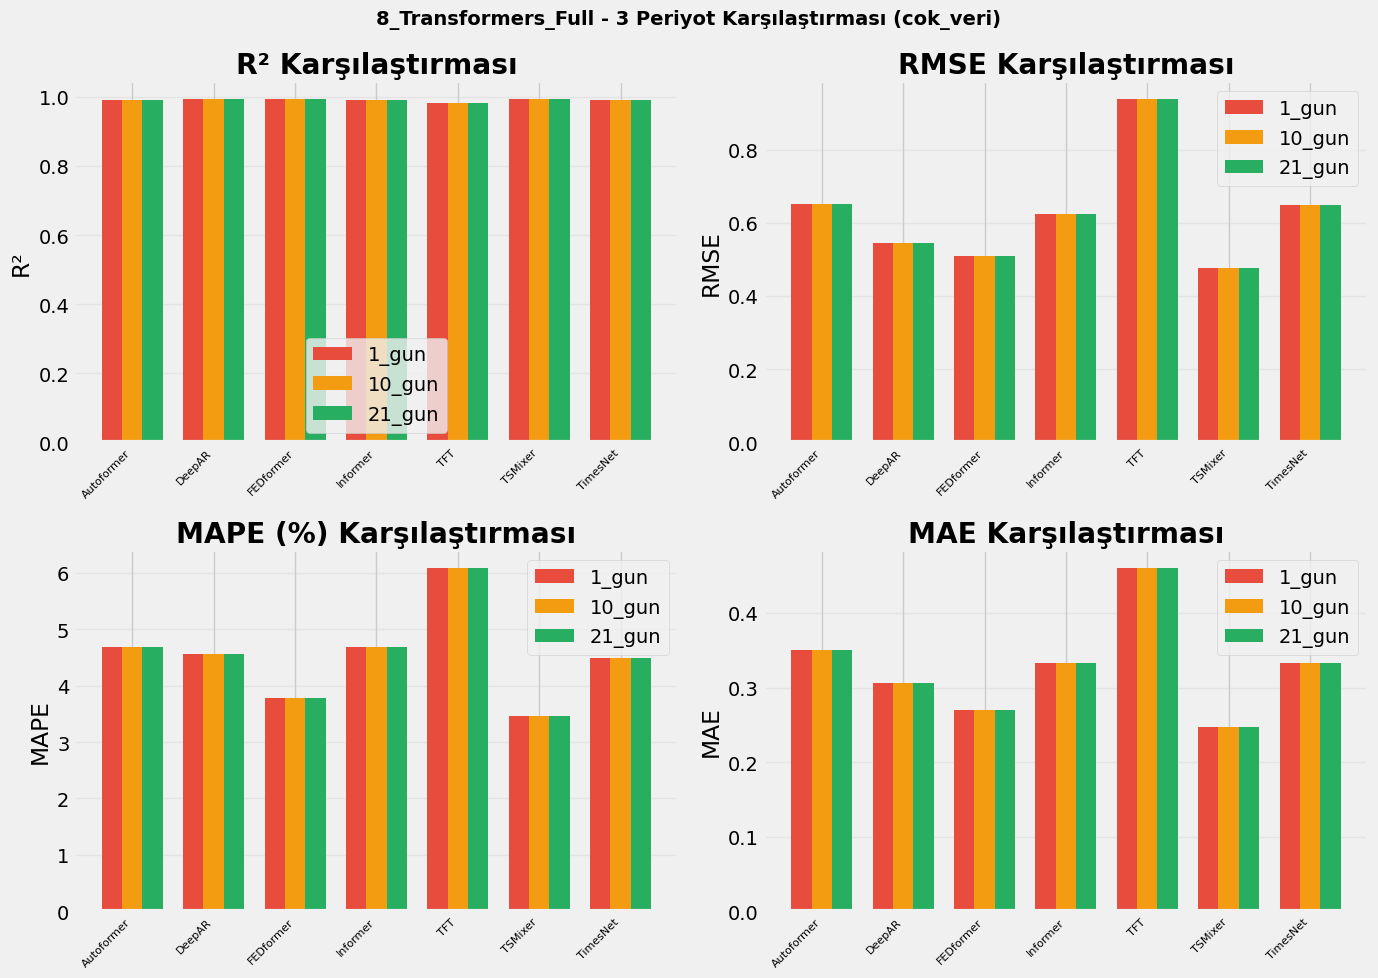


📈 Grafik kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/8_Transformers_Full/8_Transformers_Full_3periyot_karsilastirma.png


In [13]:
# =============================================================================
# KARŞILAŞTIRMA GRAFİKLERİ
# =============================================================================
if len(sonuc_df) > 0:
    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    pivot_mae = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAE', aggfunc='first')
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    pivot_mape = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAPE', aggfunc='first')

    models = pivot_rmse.index.tolist()
    x = np.arange(len(models))
    width = 0.25
    colors = ['#e74c3c', '#f39c12', '#27ae60']
    periyotlar = ['1_gun', '10_gun', '21_gun']

    # Sıralama: R²-RMSE (üst), MAPE-MAE (alt)
    grafik_ayarlari = [(pivot_r2, 'R²', 'R²'),
                       (pivot_rmse, 'RMSE', 'RMSE'),
                       (pivot_mape, 'MAPE (%)', 'MAPE'),
                       (pivot_mae, 'MAE', 'MAE')]

    def ciz_grafik():
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'{NOTEBOOK_ADI} - 3 Periyot Karşılaştırması ({VERI_TIPI})', fontsize=14, fontweight='bold')

        pozisyonlar = [(0,0), (0,1), (1,0), (1,1)]

        for (pivot, title, ylabel), (row, col) in zip(grafik_ayarlari, pozisyonlar):
            ax = axes[row, col]
            for i, periyot in enumerate(periyotlar):
                if periyot in pivot.columns:
                    values = pivot[periyot].values
                    values = np.nan_to_num(values, nan=0)
                    ax.bar(x + i*width, values, width, label=periyot, color=colors[i])
            ax.set_title(f'{title} Karşılaştırması', fontweight='bold')
            ax.set_ylabel(ylabel)
            ax.set_xticks(x + width)
            ax.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        return fig

    # 1) Hücrede göster
    fig1 = ciz_grafik()
    plt.show()

    # 2) Dosyaya kaydet
    fig2 = ciz_grafik()
    save_path = f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_3periyot_karsilastirma.png"
    fig2.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig2)
    print(f"\n📈 Grafik kaydedildi: {save_path}")

In [14]:
# =============================================================================
# EXCEL'E KAYDET
# =============================================================================
excel_dosya = f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_tum_sonuclar.xlsx"

with pd.ExcelWriter(excel_dosya, engine='openpyxl') as writer:
    sonuc_df.to_excel(writer, sheet_name='Tum_Sonuclar', index=False)
    if 'pivot_rmse' in dir():
        pivot_rmse.to_excel(writer, sheet_name='RMSE')
    if 'pivot_r2' in dir():
        pivot_r2.to_excel(writer, sheet_name='R2')
    if 'pivot_mape' in dir():
        pivot_mape.to_excel(writer, sheet_name='MAPE')

print(f"\n✅ Sonuçlar kaydedildi: {excel_dosya}")
print("\n" + "="*80)
print(f" ÖZET - {NOTEBOOK_ADI}")
print("="*80)
print(f" Veri Tipi: {VERI_TIPI}")
print(f" Kategori: {KATEGORI}")
print(f" Toplam Test: {len(sonuc_df)}")
print("="*80)


✅ Sonuçlar kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/8_Transformers_Full/8_Transformers_Full_tum_sonuclar.xlsx

 ÖZET - 8_Transformers_Full
 Veri Tipi: cok_veri
 Kategori: Transformer
 Toplam Test: 21
